# Convolutional Neural Networks
Sean Wade

The main difference between CNNs and standard DNNs is that neurons are arranged in 3 dimensions, **width, height, and depth**.  Each layer in a CNN takes in an input 3d tensor and output a 3d tensor.


There are 3 main layers in typical CNN:
- Convolutional Layer
- Pooling Layer
- Fully-Connected Layer

## Convolutional Layer

Convolutional kernels are nothing new to image processing.  This kernels are small matricies that we use for blurring, sharpening, edge detection, and more.

$
\text{Identity: } \quad 
\begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$

$
\text{Blur: } \qquad  
\begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}
$

$
\text{Sobel (edge): }  
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$

By convolving these kernels across the image we can isolate certain characteristics, or **features**.  A large number at a location after the convolution indicates a large **activation** or response to the kernel.  In the case of the sobel filter a high activation indicates there is an edge present.  This site is an awesome visualization of kernels: http://setosa.io/ev/image-kernels/

CNNs use filters like above for identifying features in 2D space.  However, the magic with CNNs is that these filters are not predetermined, but rather they are learned.  Also these leaned filters are stacked to look for complex, high level features.  For example, instead of just detecting edges we can now detect cars and tires. 

<img  src="images/cnn_filters.png"/>
<img  src="images/activations.png"/>

These filters are small spacially, meaning along the width and height, but always extend to the full depth of the input volume. For example 5x5x3 for a 224x224x3 image.

#### Hyperparameters
 - W - Input volume size
 - F - Receptive field size
 - S - Stride
 - P - Amount of 0 padding used
 
 
Output size = $\frac{(W − F+2 P)}{S}+1$

## Pooling Layer
​
The function of this layer is to reduce the spacial size of the representation. The benefit of this is three fold: reduce the amount of parameters, lower computation time, and control overfitting.  There are variants like max, average, or overlapping.
​
<img  src="./images/maxpool.jpeg"/>
​
It is worth noting that while this has been standard, a few recent publications have abandoned it.  It could be falling out of favor.


## Fully Connected Layer

A fully connected layer takes the activations and flattens them to behave like a normal layer in a DNN.  Now with all these pieces we can create a whole CNN architecture.

# Learning MNIST 

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import tensorflow as tf
import math
import random
from matplotlib import pyplot as plt
from utils import load_CIFAR10
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load in data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/MNIST_data', one_hot=True)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
mnist.train.images

0

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

## Standard DNN

In [4]:
%%time

# Placeholders
y_true = tf.placeholder(tf.float32, [None, 10])
x = tf.placeholder(tf.float32, [None, 784])

# Layer 1
W1 = weight_variable([784, 100])
b1 = bias_variable([100])
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)

# Layer 2
W2 = weight_variable([100, 10])
b2 = bias_variable([10])
y = tf.matmul(h1, W2) + b2

# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_true))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Start session
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

# Train
for i in range(5000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    if i % 1000 == 0:
        _, acc = sess.run([train_step, accuracy], feed_dict={x: batch_xs, y_true: batch_ys})
        print("step [%d]: training accuracy %g" % (i, acc))
    else:
        sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
        

# Test trained model
print("--- RESULTS ---")
print("Test Accuracy: %g" % sess.run(accuracy, feed_dict={x: mnist.test.images,
                              y_true: mnist.test.labels}))
sess.close()

step [0]: training accuracy 0.09
step [1000]: training accuracy 0.98
step [2000]: training accuracy 0.95
step [3000]: training accuracy 0.98
step [4000]: training accuracy 0.99
--- RESULTS ---
Test Accuracy: 0.9769
CPU times: user 32.7 s, sys: 2.61 s, total: 35.3 s
Wall time: 15.7 s


## Vanilla CNN

This is the most basic CNN.  It has 2 convolutional layers and 2 fully connected layers.

In [3]:
def conv2d(x, W):
    # [batch, in_height, in_width, in_channels]
    # [filter_height, filter_width, in_channels, out_channels]
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [5]:
%%time

# Placeholders
y_true = tf.placeholder(tf.float32, [None, 10])
x = tf.placeholder(tf.float32, [None, 784])

# Resize to appropriate input tensor:
# [batch, in_height, in_width, in_channels]
x_image = tf.reshape(x, [-1,28,28,1])

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# Second Convolitional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([28*28*64, 1024])
b_fc1 = bias_variable([1024])
h_conv2_flat = tf.reshape(h_conv2, [-1, 28*28*64])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_true))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(5000):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
        _, acc = sess.run([train_step, accuracy], feed_dict={x: batch[0], y_true: batch[1]})
        print("step [%d]: training accuracy %g" % (i, acc))
    else:
        sess.run(train_step, feed_dict={x: batch[0], y_true: batch[1]})

print("--- RESULTS ---")
print("Test Accuracy %g" % accuracy.eval(feed_dict={
    x: mnist.test.images, y_true: mnist.test.labels}))

sess.close()

step [0]: training accuracy 0.1
step [1000]: training accuracy 1
step [2000]: training accuracy 0.98
step [3000]: training accuracy 0.98
step [4000]: training accuracy 0.98
--- RESULTS ---
Test Accuracy 0.9835
CPU times: user 4h 28min 31s, sys: 21min 36s, total: 4h 50min 7s
Wall time: 1h 29min 54s


## CNN + Tricks

This CNN is the same as above plus max pooling and dropout.

In [4]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [6]:
%%time

# Placeholders
y_true = tf.placeholder(tf.float32, [None, 10])
x = tf.placeholder(tf.float32, [None, 784])
keep_prob = tf.placeholder(tf.float32)

# Resize to appropriate input tensor:
# [batch, in_height, in_width, in_channels]
x_image = tf.reshape(x, [-1,28,28,1])

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1) # <------------------------- Added Pooling

# Second Convolitional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) # <------------------------- Added Pooling

# Densely Connected Layer
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) # <------------ Added Dropout

# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_true))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(5000):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
        _, acc = sess.run([train_step, accuracy], feed_dict={x: batch[0], y_true: batch[1], keep_prob: 1.0})
        print("step [%d]: training accuracy %g" % (i, acc))
    else:
        sess.run(train_step, feed_dict={x: batch[0], y_true: batch[1], keep_prob: .5})

print("--- RESULTS ---")
print("Test Accuracy %g" % accuracy.eval(feed_dict={
    x: mnist.test.images, y_true: mnist.test.labels, keep_prob: 1.0}))

sess.close()

step [0]: training accuracy 0.1
step [1000]: training accuracy 0.92
step [2000]: training accuracy 0.94
step [3000]: training accuracy 1
step [4000]: training accuracy 0.98
--- RESULTS ---
Test Accuracy 0.9874
CPU times: user 43min 52s, sys: 4min 49s, total: 48min 41s
Wall time: 15min 53s


## CIFAR-10

MNIST is easy, lets ramp it up.  The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.  This is the smallest, most manageable photo classification data set.  It is a standard for many basic models.

In [11]:
cifar = load_CIFAR10('./data/cifar-10/')

In [22]:
print('Training Shape:'.ljust(22), cifar.x_train.shape)
print('Training Label Shape:'.ljust(22), cifar.y_train.shape)
print('Test Shape:'.ljust(22), cifar.x_test.shape)
print('Test Label Shape:'.ljust(22), cifar.y_test.shape)

Training Shape:        (50000, 32, 32, 3)
Training Label Shape:  (50000, 10)
Test Shape:            (10000, 32, 32, 3)
Test Label Shape:      (10000, 10)


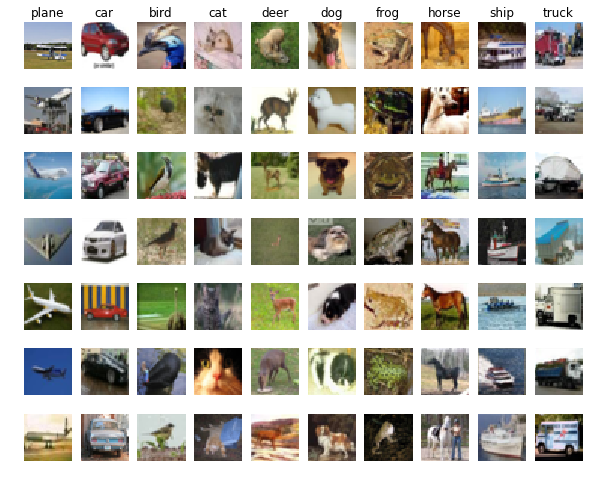

In [7]:
# Visualize some examples from the dataset.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(cifar.y_train_num == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cifar.x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Just plugging the data into the simple CNN used above didn't work... The accuracy would improve to 25% and then drop to 10% (random guessing).  The problem turned out to be weight initialization.  The following initialization is robust over time for Relu nonlinearities.  This allowed the network to work for 1000 epochs.  However it would then break. The key to fixing this was using batch normalization to keep the activations normal.

### Batch Normalization

**Input: ** Values of $x$ over a mini-batch: $B = \{x_1,...x_m\}$;

**Output: ** $\{y_i = \text{BN}_{\gamma, \beta}(x_i)\}$

**Algorithm:**

mini-batch mean: $$\qquad \mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i$$

mini-batch variance: $$\qquad \sigma_B^2 \leftarrow \frac{1}{m}\sum_{i=1}^m (x_i - \mu_B)^2$$

normalize: $$\qquad \hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

scale and shift: $$\qquad \gamma \hat{x_i} + \beta \equiv \text{BN}_{\gamma, \beta}(x_i)$$

In [8]:
def weight_variable(shape, name):
    """
    Weight initialization using method from He et al (2015).
    Args:
      shape: (list) Dimensions of weight
      name: (string) Name of the weight
    Returns:
      W: (tf.Variable) Initialized weight tensor
    """
    initializer = tf.constant_initializer()
    fan_in = shape[0] if len(shape) == 2 else np.prod(shape[:-1])
    std = math.sqrt(2.0 / fan_in)
    initializer = tf.random_normal_initializer(stddev=std)
    return  tf.get_variable(name, shape, initializer=initializer)

In [9]:
def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Args:
        x: (tensor) 4D BHWD input maps
        n_out (int) depth of input maps
        phase_train: (boolean) true indicates training phase
    Return:
        normed: (tensor) batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [10]:
# Placeholders
y_true = tf.placeholder(tf.float32, [None, 10])
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 3, 32], name='W_conv1')
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Batch Normalization
h_normed1 = batch_norm(h_pool1, 32, is_training)

# Second Convolitional Layer
W_conv2 = weight_variable([5, 5, 32, 64],  name='W_conv2')
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_normed1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Batch Normalization
h_normed2 = batch_norm(h_pool2, 64, is_training)

# Densely Connected Layer
W_fc1 = weight_variable([8*8*64, 1024],  name='W_fc1')
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_normed2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable([1024, 10], name='W_fc2')
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_true))
train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
summary_writer = tf.train.SummaryWriter( "./cifar_log", graph=sess.graph )
accuarcy_summary = tf.scalar_summary("accuracy", accuracy)
cross_entropy_summary = tf.scalar_summary("loss", cross_entropy)
merged = tf.merge_all_summaries()

for i in range(3000):
    batch = cifar.next_batch()
    if i % 10 == 0:
        summary, _, acc, loss = sess.run([merged, train_step, accuracy, cross_entropy], feed_dict={x: batch[0], y_true: batch[1], keep_prob: 1.0, is_training: True})
        summary_writer.add_summary(summary, i)
        if i % 250 == 0:
            print("step %-5d: acc %5g  loss %5g" % (i, acc, loss))
    else:
        sess.run(train_step, feed_dict={x: batch[0], y_true: batch[1], keep_prob: .5, is_training: True})

print("--- RESULTS ---")
print("Test Accuracy %g" % accuracy.eval(feed_dict={
    x: cifar.x_test, y_true: cifar.y_test, keep_prob: 1.0, is_training: False}))

summary_writer.close()
sess.close()

step 0    : acc  0.14  loss 3.15356
step 250  : acc  0.16  loss 2.03865
step 500  : acc  0.21  loss 2.05403
step 750  : acc  0.22  loss 1.94305
step 1000 : acc  0.31  loss 1.822
step 1250 : acc  0.31  loss 1.71156
step 1500 : acc  0.31  loss 1.76807
step 1750 : acc  0.35  loss 1.74905
step 2000 : acc  0.43  loss 1.55972
step 2250 : acc  0.54  loss 1.40106
step 2500 : acc  0.49  loss 1.34232
step 2750 : acc  0.57  loss 1.31911
--- RESULTS ---
Test Accuracy 0.5697


## CNN Architectures

<img src="./images/full_net.png">

The most common architecture follow the following pattern.

INPUT - > [[CONV -> RELU]xN -> POOL?]xM -> [FC -. RELU]xk -> FC

<img src="./images/vgg.png">

There are several standard architectures that are legendary (standard and influential).

#### AlexNet
- Trained the network on ImageNet data, which contained over 15 million annotated images from a total of over 22,000 categories.
- Used ReLU for the nonlinearity functions (Found to decrease training time as ReLUs are several times faster than the conventional tanh function).
- Used data augmentation techniques that consisted of image translations, horizontal reflections, and patch extractions.
- Implemented dropout layers in order to combat the problem of overfitting to the training data.
- Trained the model using batch stochastic gradient descent, with specific values for momentum and weight decay.
- Trained on two GTX 580 GPUs for five to six days.

#### ZF Net
- Very similar architecture to AlexNet, except for a few minor modifications.
- AlexNet trained on 15 million images, while ZF Net trained on only 1.3 million images.
- Instead of using 11x11 sized filters in the first layer (which is what AlexNet implemented), ZF Net used filters of size 7x7 and a decreased stride value. The reasoning behind this modification is that a smaller filter size in the first conv layer helps retain a lot of original pixel information in the input volume. A filtering of size 11x11 proved to be skipping a lot of relevant information, especially as this is the first conv layer.
- As the network grows, we also see a rise in the number of filters used.
- Used ReLUs for their activation functions, cross-entropy loss for the error function, and trained using batch stochastic gradient descent.
- Trained on a GTX 580 GPU for twelve days.
- Developed a visualization technique named Deconvolutional Network, which helps to examine different feature activations and their relation to the input space. Called “deconvnet” because it maps features to pixels (the opposite of what a convolutional layer does).

#### VGG Net
- The use of only 3x3 sized filters is quite different from AlexNet’s 11x11 filters in the first layer and ZF Net’s 7x7 filters. The authors’ reasoning is that the combination of two 3x3 conv layers has an effective receptive field of 5x5. This in turn simulates a larger filter while keeping the benefits of smaller filter sizes. One of the benefits is a decrease in the number of parameters. Also, with two conv layers, we’re able to use two ReLU layers instead of one.
- 3 conv layers back to back have an effective receptive field of 7x7.
- As the spatial size of the input volumes at each layer decrease (result of the conv and pool layers), the depth of the volumes increase due to the increased number of filters as you go down the network.
- Interesting to notice that the number of filters doubles after each maxpool layer. This reinforces the idea of shrinking spatial dimensions, but growing depth.
- Worked well on both image classification and localization tasks. The authors used a form of localization as regression (see page 10 of the paper for all details).
- Built model with the Caffe toolbox.
- Used scale jittering as one data augmentation technique during training.
- Used ReLU layers after each conv layer and trained with batch gradient descent.
- Trained on 4 Nvidia Titan Black GPUs for two to three weeks.

#### GoogLeNet
- Used 9 Inception modules in the whole architecture, with over 100 layers in total! Now that is deep…
- No use of fully connected layers! They use an average pool instead, to go from a 7x7x1024 volume to a 1x1x1024 volume. This saves a huge number of parameters.
- Uses 12x fewer parameters than AlexNet.
- During testing, multiple crops of the same image were created, fed into the network, and the softmax probabilities were averaged to give us the final solution.
- Utilized concepts from R-CNN (a paper we’ll discuss later) for their detection model.
- There are updated versions to the Inception module (Versions 6 and 7).
- Trained on “a few high-end GPUs within a week”.

#### ResNet
- “Ultra-deep” – Yann LeCun.
- 152 layers…
- Interesting note that after only the first 2 layers, the spatial size gets compressed from an input volume of 224x224 to a 56x56 volume.
- Authors claim that a naïve increase of layers in plain nets result in higher training and test error (Figure 1 in the paper).
- The group tried a 1202-layer network, but got a lower test accuracy, presumably due to overfitting.
- Trained on an 8 GPU machine for two to three weeks.

## Useful Links:
Interactive Demo:
- http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html
- http://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html

Visualizing Activations:
- https://www.youtube.com/watch?v=AgkfIQ4IGaM

Sources:

[1] http://cs231n.github.io/convolutional-networks/

[2] https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/